In [1]:
import scipy.integrate as integrate 
import math
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.integrate as integrate 
import cmath 
from scipy import optimize
from scipy.misc import derivative

from decimal import Decimal
from decimal import *
getcontext().prec = 64


In [2]:
 #Defining the (exact) Bosonic and fermionic thermal functions to be used it the effective potential

def Jb(m,T):
    
    def integrand(k,m,T):    
        return k**2*np.log(1 - np.exp(-np.sqrt(k**2 + (m/T)**2)))
        
    return T**4/(2*np.pi**2)*integrate.quad(integrand, 0, np.inf, args = (m,T))[0]   

def Jf(m,T):
    
    def integrand(k,m, T):    
        return k**2*np.log(1 + np.exp(-np.sqrt(k**2 + (m/T)**2)))
                                  
    return T**4/(2*np.pi**2)*integrate.quad(integrand, 0, np.inf, args = (m,T))[0]


In [4]:
# Parameters and effective masses to be used in the effective potential
# constants of higgs tree level potential
mu = 3000
lam = 0.01
c6 = -1/10000
Lam = 246

#yukawa coupling constant of fermion f 
y_f = 0.99                                          #(for the top quark)

#EW - sector coupling constants g (SU(2)_L) and g_p (U(1)_Y) 
g = 0.65
g_p = 0.36
eps = 0.00001


# Effective mass of fermion f acquired through yukawa coupling w/ the Higgs
def m_f(phi):
    return y_f**2/2*phi**2 + eps

# W and Z boson masses
def m_W(phi):
    return (g**2/4)*phi**2 + eps

def m_Z(phi):
    return (g**2 + g_p**2)*phi**2/4 + eps

# Higgs and Goldstone masses
def m_h(phi):                                               
    return 3*lam*phi**2 - mu**2 - (15/4)*c6*phi**4 + eps

#m_h 0 at h_min = (2/5)*(lam/c6)*(1 - np.sqrt(1-5/3*c6*(mu**2)/lam**2))

def m_g(phi):
    return lam*phi**2 - mu**2 - (3/4)*c6*phi**4 + eps

Text(0.5, 1.0, '1-loop effective potential at T = 1005')

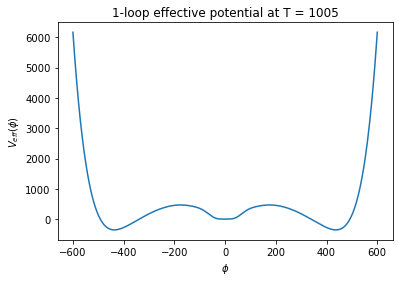

In [126]:
Lam = 246     # regulator/Cutoff(?)

#1-loop effective potential
def v_eff(phi,T):
    return np.real(-(mu**2)/2*phi**2 + (lam/4)*phi**4 - (c6/8)*phi**6
            + m_h(phi)**2/(64*np.pi**2)*(cmath.log(m_h(phi)/Lam) - 3/2) + Jb(m_h(phi),T)
           + 3*m_g(phi)**2/(64*np.pi**2)*(cmath.log(m_g(phi)/Lam) - 3/2) + 3*Jb(m_g(phi),T)
            + 3*m_Z(phi)**2/(64*np.pi**2)*(cmath.log(m_Z(phi)/Lam) - 5/6) + 3*Jb(m_Z(phi),T)
            + 6*m_W(phi)**2/(64*np.pi**2)*(cmath.log(m_W(phi)/Lam) - 5/6) + 6*Jb(m_W(phi),T)    
            - 12*m_f(phi)**2/(64*np.pi**2)*(cmath.log(m_f(phi)/Lam) - 3/2) - 12*Jf(m_f(phi),T)
           )/(Lam**4)

vecv_eff = np.vectorize(v_eff)


phi = np.linspace(-600, 600, 500)
T = 1005
arrv_eff = vecv_eff(phi,T) - v_eff(0,T)


plt.plot(phi, arrv_eff)
#plt.legend(loc = "lower left")
plt.xlabel('$\phi$')
plt.ylabel('$V_{eff}(\phi)$')
plt.title('1-loop effective potential at T = %1.0f'  % T)
#plt.ylim(-0.1*1e13, 1*1e13)

#Tree level min
#phi_min = ((2*lam)/(3*c6))*(1 - np.sqrt(1 - (3*c6*mu**2)/(lam**2)))


In [109]:
# Finding the bounce action at some nucleation temperature later tn chosen s.t s3/tn ~ 140.  
tn = 1005

def v_eff_tn(phi):
    return np.vectorize(v_eff)(phi,tn) - np.vectorize(v_eff)(0,tn)

arrv_eff = vecv_eff(phi,tn) - v_eff(0,tn)

def v_p(phi):
    return derivative(v_eff_tn, phi, dx = 0.00001, order=3)

def f(t,y):    
    A = y[0]
    B = y[1]
    
    dA_dt = B
    dB_dt = v_p(A) - (2/t)*B                                
    return np.array([dA_dt, dB_dt])


In [110]:
minimum = optimize.fmin(v_eff_tn, 0)[0]

#finding phi within tolerance to use as stop condition for overshoot/undershoot
x = np.linspace(0,10,100)
tol1 = 1e-2


symm_vac = x[np.max(np.where(np.abs(v_eff_tn(x) - (-0.021415))<tol1))]
broken_vac = optimize.fmin(v_eff_tn, 600)[0]
print(symm_vac)

Optimization terminated successfully.
         Current function value: -0.021202
         Iterations: 30
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -358.075765
         Iterations: 24
         Function evaluations: 48
7.575757575757575


4.825234048132
4.825234048132


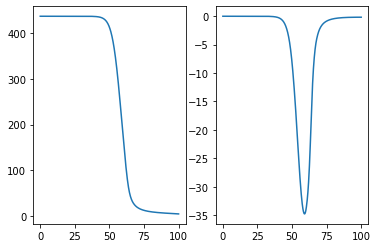

In [111]:
#Solving EOM for the bounce solution, span, ic. gotten from the overshoot-undershoot procedure. 

t_span = np.array([eps, 100])

times  = np.linspace(t_span[0], t_span[1], 1000)

y0 = np.array([436.88922485470766, 0])                        

soln = solve_ivp(f, t_span, y0, t_eval = times)

r = soln.t
phi_b = soln.y[0]
dphi_b = soln.y[1]

print(phi_b[-1])
print(min(phi_b))

plt.subplot(1,2,1)
plt.plot(r,phi_b) 

plt.subplot(1,2,2)
plt.plot(r,dphi_b)

In [112]:
##calculating the bounce action, first we need the radius of the bubble. 

#Effective potential values of phi = bounce.  
v_b = vecv_eff(phi_b,tn) - vecv_eff(broken_vac,tn)
print('Go!')

Go!


Bounce action over temperature 928817.1474089328


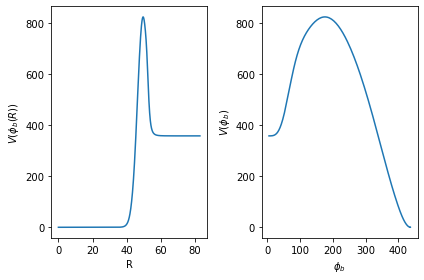

In [122]:
##calculating the bounce action, first we need the radius of the bubble. 
#Find the index of the first value which satisfies the critical bubble's solution. and then let that be the bubble wall.

index_r = np.where(np.abs(phi_b - symm_vac) <= 9e-1)
r_max = r[np.min(index_r)]
dphi_b = soln.y[1]

# R is the interval over which we want to integrate the functional over to get the bounce action.
# L is the euclidean lagrangian density to be integrated.  



R = np.linspace(0, r_max, len(phi_b))
L = ((1/2)*dphi_b**2 + v_b)

s3 = 4*np.pi*np.trapz((R**2)*L, R)
print('Bounce action over temperature', s3/tn)

# s3/tn = 928817 for tn = 1005,    y0 = 436.88922485470766, t_end = 100
# s3/tn = 890854 for tn = 1000,    y0 = 436.8892224311828,  t_end = 100
# s3/tn = 427425 for tn = 900,     y0 = 436.8447265625,     t_end = 60
# s3/tn = 389186 for tn = 800      y0 = 435.66070783561736  t_end = 55...


plt.subplot(1,2,1)
plt.plot(R, v_b)
plt.xlabel('R')
plt.ylabel('$V(\phi_b(R))$')
plt.subplot(1,2,2)
plt.plot(phi_b,v_b)
plt.xlabel('$\phi_b$')
plt.ylabel('$V(\phi_b)$')

plt.tight_layout()


In [104]:
##Calculating the latent heat
def v_symm(T):
    return v_eff(symm_vac,T)

def v_broken(T):
    return v_eff(broken_vac,T)

# need derivative of the effective potential w.r.t. T at the symmetric and broken phases. 

def dv_symm(T):
    return derivative(v_symm,T ,dx=0.0001, order=3)

def dv_broken(T):
    return derivative(v_broken,T ,dx=0.0001, order=3)



g_star = 109.65
rho_rad = np.pi**2*g_star*(tn**4)/30
del_v = v_eff_tn(symm_vac) - v_eff_tn(broken_vac)
del_dv = dv_symm(tn) - dv_broken(tn)

alpha = (1/rho_rad)*(del_v - (1/4)*del_dv)


print(rho_rad)
print(del_v)
print(del_dv)
print(alpha*(Lam**4))

14775666313618.064
714.5746521454943
-1.1955894510151666
0.17718321679842952


In [ ]:
#Calculating the 


